In [1]:

import tensorflow as tf### models
import pandas as pd ### reading and processing data
import seaborn as sns ### visualization
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
from tensorflow.keras.layers import Normalization, Dense, InputLayer
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
data = pd.read_csv("train.csv", sep= ",")
data.head()

v.id  on road old  on road now  years      km  rating  condition  economy  \
0     1       535651       798186      3   78945       1          2       14   
1     2       591911       861056      6  117220       5          9        9   
2     3       686990       770762      2  132538       2          8       15   
3     4       573999       722381      4  101065       4          3       11   
4     5       691388       811335      6   61559       3          9       12   

   top speed  hp  torque  current price  
0        177  73     123       351318.0  
1        148  74      95       285001.5  
2        181  53      97       215386.0  
3        197  54     116       244295.5  
4        160  53     105       531114.5

# Data Preparation

In [3]:
data.shape

(1000, 12)

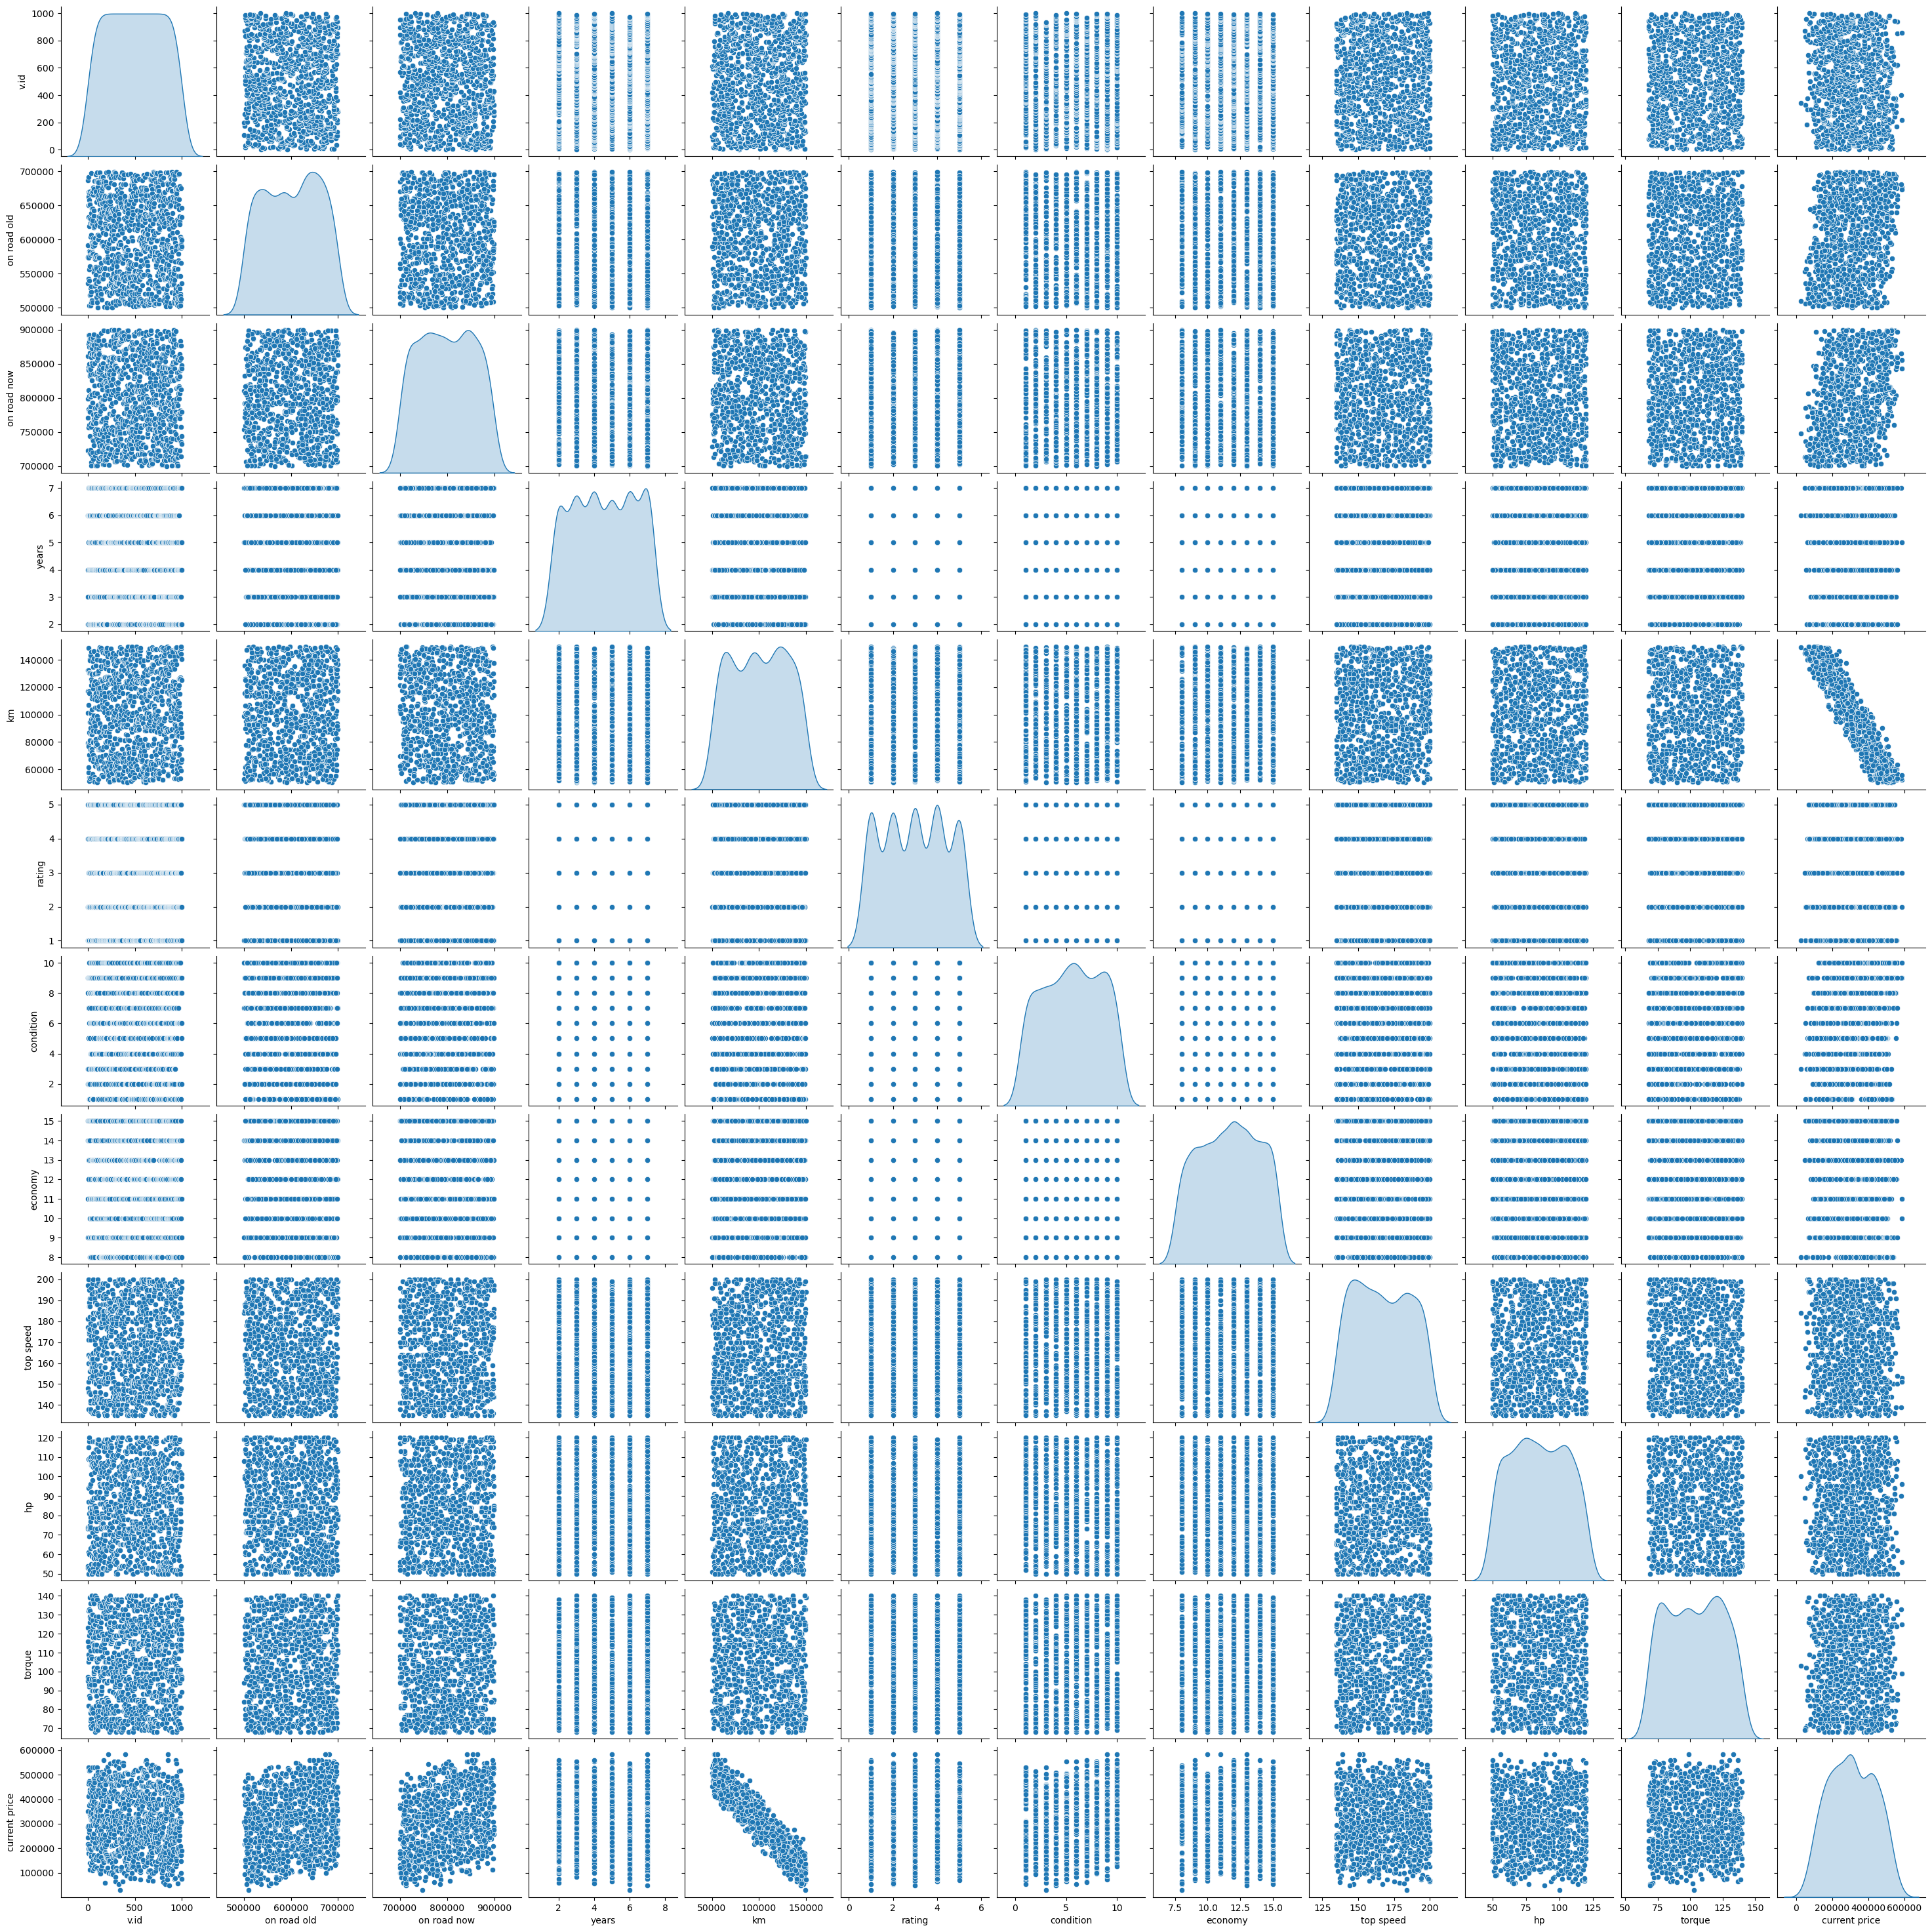

In [4]:
columns_to_plot = ['v.id', 'on road old', 'on road now', 'years', 'km', 'rating', 'condition', 'economy', 'top speed', 'hp', 'torque', 'current price']
sns.pairplot(data[columns_to_plot], diag_kind='kde')

In [5]:
tensor_data = tf.random.shuffle(tf.cast(tf.constant(data),tf.float32))
tensor_data = tf.constant(data)
tensor_data = tf.cast(tensor_data,tf.float32)
tensor_data = tf.random.shuffle(tensor_data)
print(tensor_data)

tf.Tensor(
[[9.200000e+01 5.248370e+05 8.623880e+05 ... 1.100000e+02 1.390000e+02
  2.409260e+05]
 [2.680000e+02 5.488610e+05 8.579010e+05 ... 1.200000e+02 8.900000e+01
  4.048005e+05]
 [9.300000e+01 5.355740e+05 7.403960e+05 ... 7.700000e+01 7.600000e+01
  3.819600e+05]
 ...
 [4.810000e+02 5.174510e+05 7.708750e+05 ... 7.600000e+01 7.300000e+01
  4.336020e+05]
 [1.820000e+02 6.638770e+05 7.127810e+05 ... 7.400000e+01 7.400000e+01
  1.854855e+05]
 [7.790000e+02 5.913560e+05 8.249110e+05 ... 8.200000e+01 1.090000e+02
  3.316870e+05]], shape=(1000, 12), dtype=float32)


In [6]:
X = tensor_data[:,3:-1]
print(X.shape)
print(X)

(1000, 8)
tf.Tensor(
[[5.00000e+00 1.12977e+05 1.00000e+00 ... 1.94000e+02 1.10000e+02
  1.39000e+02]
 [2.00000e+00 7.51160e+04 5.00000e+00 ... 1.58000e+02 1.20000e+02
  8.90000e+01]
 [7.00000e+00 6.44570e+04 5.00000e+00 ... 1.59000e+02 7.70000e+01
  7.60000e+01]
 ...
 [4.00000e+00 5.25680e+04 1.00000e+00 ... 1.51000e+02 7.60000e+01
  7.30000e+01]
 [4.00000e+00 1.25669e+05 1.00000e+00 ... 1.53000e+02 7.40000e+01
  7.40000e+01]
 [3.00000e+00 9.42940e+04 3.00000e+00 ... 1.80000e+02 8.20000e+01
  1.09000e+02]], shape=(1000, 8), dtype=float32)


In [7]:
y = tensor_data[:,-1]
print(y.shape)
y= tf.expand_dims( #to add extra dimention so that it matches that of the inputs 
    y, axis=-1
)
print(y.shape)

(1000,)
(1000, 1)


In [8]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
DATASET_SIZE = len(X)

In [9]:
print(DATASET_SIZE)
print(len(y))

1000
1000


In [10]:
X_train = X[:int(DATASET_SIZE*TRAIN_RATIO)]
y_train = y[:int(DATASET_SIZE*TRAIN_RATIO)]
print(X_train.shape)
print(y_train.shape)

(800, 8)
(800, 1)


In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
train_dataset = train_dataset.shuffle( buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [12]:
print(len(y))

1000



In [13]:
X_val = X[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]
y_val = y[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]
print(X_val.shape)
print(y_val.shape)

(100, 8)
(100, 1)


In [14]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val,y_val))
val_dataset = train_dataset.shuffle( buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [15]:
X_test = X[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):]
y_test = y_val = y[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):]
print(X_test.shape)
print(y_test.shape)

(100, 8)
(100, 1)


In [16]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test))
test_dataset = train_dataset.shuffle( buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

Normalize to train faster

In [17]:
normalizer = Normalization()
normalizer.adapt(X_train)
normalizer(X)[:5]

<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
array([[ 0.2563684 ,  0.4387952 , -1.4413736 , -0.56027335, -0.7725107 ,
         1.4206593 ,  1.2597691 ,  1.7174776 ],
       [-1.4817201 , -0.871606  ,  1.4341856 , -0.91403717, -1.672742  ,
        -0.43716767,  1.7482407 , -0.6614652 ],
       [ 1.415094  , -1.240523  ,  1.4341856 ,  0.50101805,  0.5778362 ,
        -0.38556135, -0.3521877 , -1.2799903 ],
       [ 1.415094  , -1.2737148 , -1.4413736 ,  1.5623095 , -0.7725107 ,
         0.3369269 ,  1.1620747 , -1.4703057 ],
       [-0.9023572 , -0.88385826, -0.7224838 , -0.20650955, -0.7725107 ,
        -1.4692937 , -0.4010349 , -1.4227269 ]], dtype=float32)>

In [18]:
print(X[:5])

tf.Tensor(
[[5.00000e+00 1.12977e+05 1.00000e+00 4.00000e+00 1.00000e+01 1.94000e+02
  1.10000e+02 1.39000e+02]
 [2.00000e+00 7.51160e+04 5.00000e+00 3.00000e+00 8.00000e+00 1.58000e+02
  1.20000e+02 8.90000e+01]
 [7.00000e+00 6.44570e+04 5.00000e+00 7.00000e+00 1.30000e+01 1.59000e+02
  7.70000e+01 7.60000e+01]
 [7.00000e+00 6.34980e+04 1.00000e+00 1.00000e+01 1.00000e+01 1.73000e+02
  1.08000e+02 7.20000e+01]
 [3.00000e+00 7.47620e+04 2.00000e+00 5.00000e+00 1.00000e+01 1.38000e+02
  7.60000e+01 7.30000e+01]], shape=(5, 8), dtype=float32)


# Model creation and training

In [21]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(None, 8)),
    normalizer,
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, 8)          17        
 n)                                                              
                                                                 
 dense (Dense)               (None, None, 128)         1152      
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, 8)          17        
 n)                                                              
                                                                 
 dense (Dense)               (None, None, 128)         1152      
                                                                 
 dense_1 (Dense)             (None, None, 128)         1

In [22]:
tf.keras.utils.plot_model(model,to_file="mode.png",show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Model Compile

In [23]:
model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss=MeanAbsoluteError(),
    metrics=[RootMeanSquaredError()]
)

In [24]:
print(len(train_dataset))
print(len(val_dataset))

25
1


In [25]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1)

Epoch 1/100
25/25 [==============================] - 2s 17ms/step - loss: 162200.6562 - root_mean_squared_error: 208103.9219 - val_loss: 62836.6797 - val_root_mean_squared_error: 79837.8906
Epoch 2/100
25/25 [==============================] - 0s 4ms/step - loss: 58916.7695 - root_mean_squared_error: 74536.6250 - val_loss: 46139.4102 - val_root_mean_squared_error: 57399.7500
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 45386.1836 - root_mean_squared_error: 57238.6055 - val_loss: 43664.6445 - val_root_mean_squared_error: 54521.4531
Epoch 4/100
25/25 [==============================] - 0s 4ms/step - loss: 51393.0117 - root_mean_squared_error: 63445.9531 - val_loss: 74080.4688 - val_root_mean_squared_error: 90449.5234
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 52731.1758 - root_mean_squared_error: 65423.3125 - val_loss: 59718.5117 - val_root_mean_squared_error: 74914.8906
Epoch 6/100
25/25 [==============================] - 0s 5ms/st

In [26]:
history.history

{'loss': [162200.65625,
  58916.76953125,
  45386.18359375,
  51393.01171875,
  52731.17578125,
  48749.88671875,
  44371.88671875,
  44568.89453125,
  44695.9609375,
  43967.16015625,
  46596.05078125,
  47682.0,
  40661.9140625,
  42383.390625,
  40286.796875,
  41337.6796875,
  40677.0,
  38514.96484375,
  40786.22265625,
  45089.23046875,
  43017.7109375,
  39175.859375,
  37527.1640625,
  37892.7890625,
  39524.19140625,
  38112.390625,
  36687.40625,
  41512.0859375,
  53303.39453125,
  46660.625,
  45909.0234375,
  50127.109375,
  42134.58984375,
  41409.78125,
  41115.19140625,
  39329.60546875,
  39461.203125,
  38209.65625,
  37208.703125,
  36254.0390625,
  36451.6640625,
  39976.08984375,
  42786.68359375,
  39260.07421875,
  38654.37109375,
  36083.4375,
  35149.60546875,
  35671.98046875,
  39702.42578125,
  37262.6328125,
  37560.671875,
  38826.953125,
  38191.9609375,
  36877.14453125,
  37261.09375,
  38117.78125,
  39595.66796875,
  36277.6796875,
  33935.99609375,
 

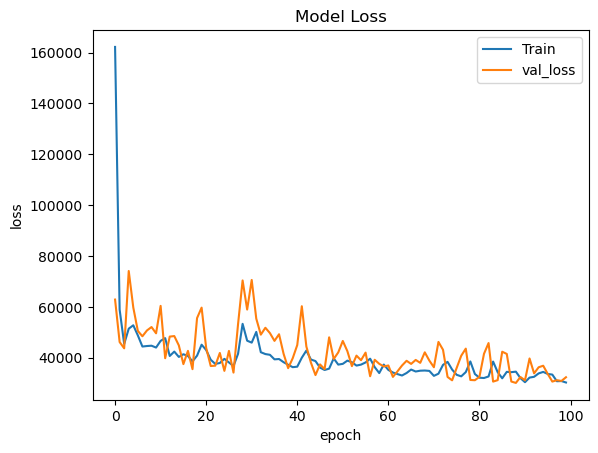

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','val_loss'])
plt.show()

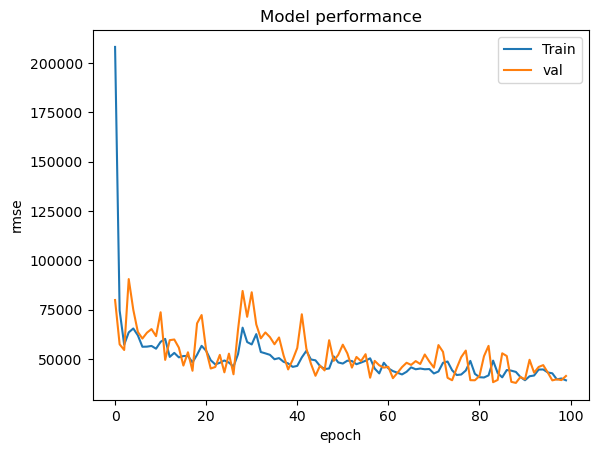

In [28]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model performance')
plt.xlabel('epoch')
plt.ylabel('rmse')
plt.legend(['Train','val'])
plt.show()

In [29]:
model.evaluate(X_test,y_test)

4/4 [==============================] - 0s 3ms/step - loss: 42301.9648 - root_mean_squared_error: 51251.3125


[42301.96484375, 51251.3125]

In [30]:
model.predict(tf.expand_dims(X_test[0],axis=0))

1/1 [==============================] - 0s 134ms/step


array([[341661.4]], dtype=float32)

In [31]:
y_test[0]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([273728.], dtype=float32)>

In [32]:
y_true = list(y_test[:,0].numpy())

In [33]:
y_pred = list(model.predict(X_test)[:,0])

4/4 [==============================] - 0s 2ms/step


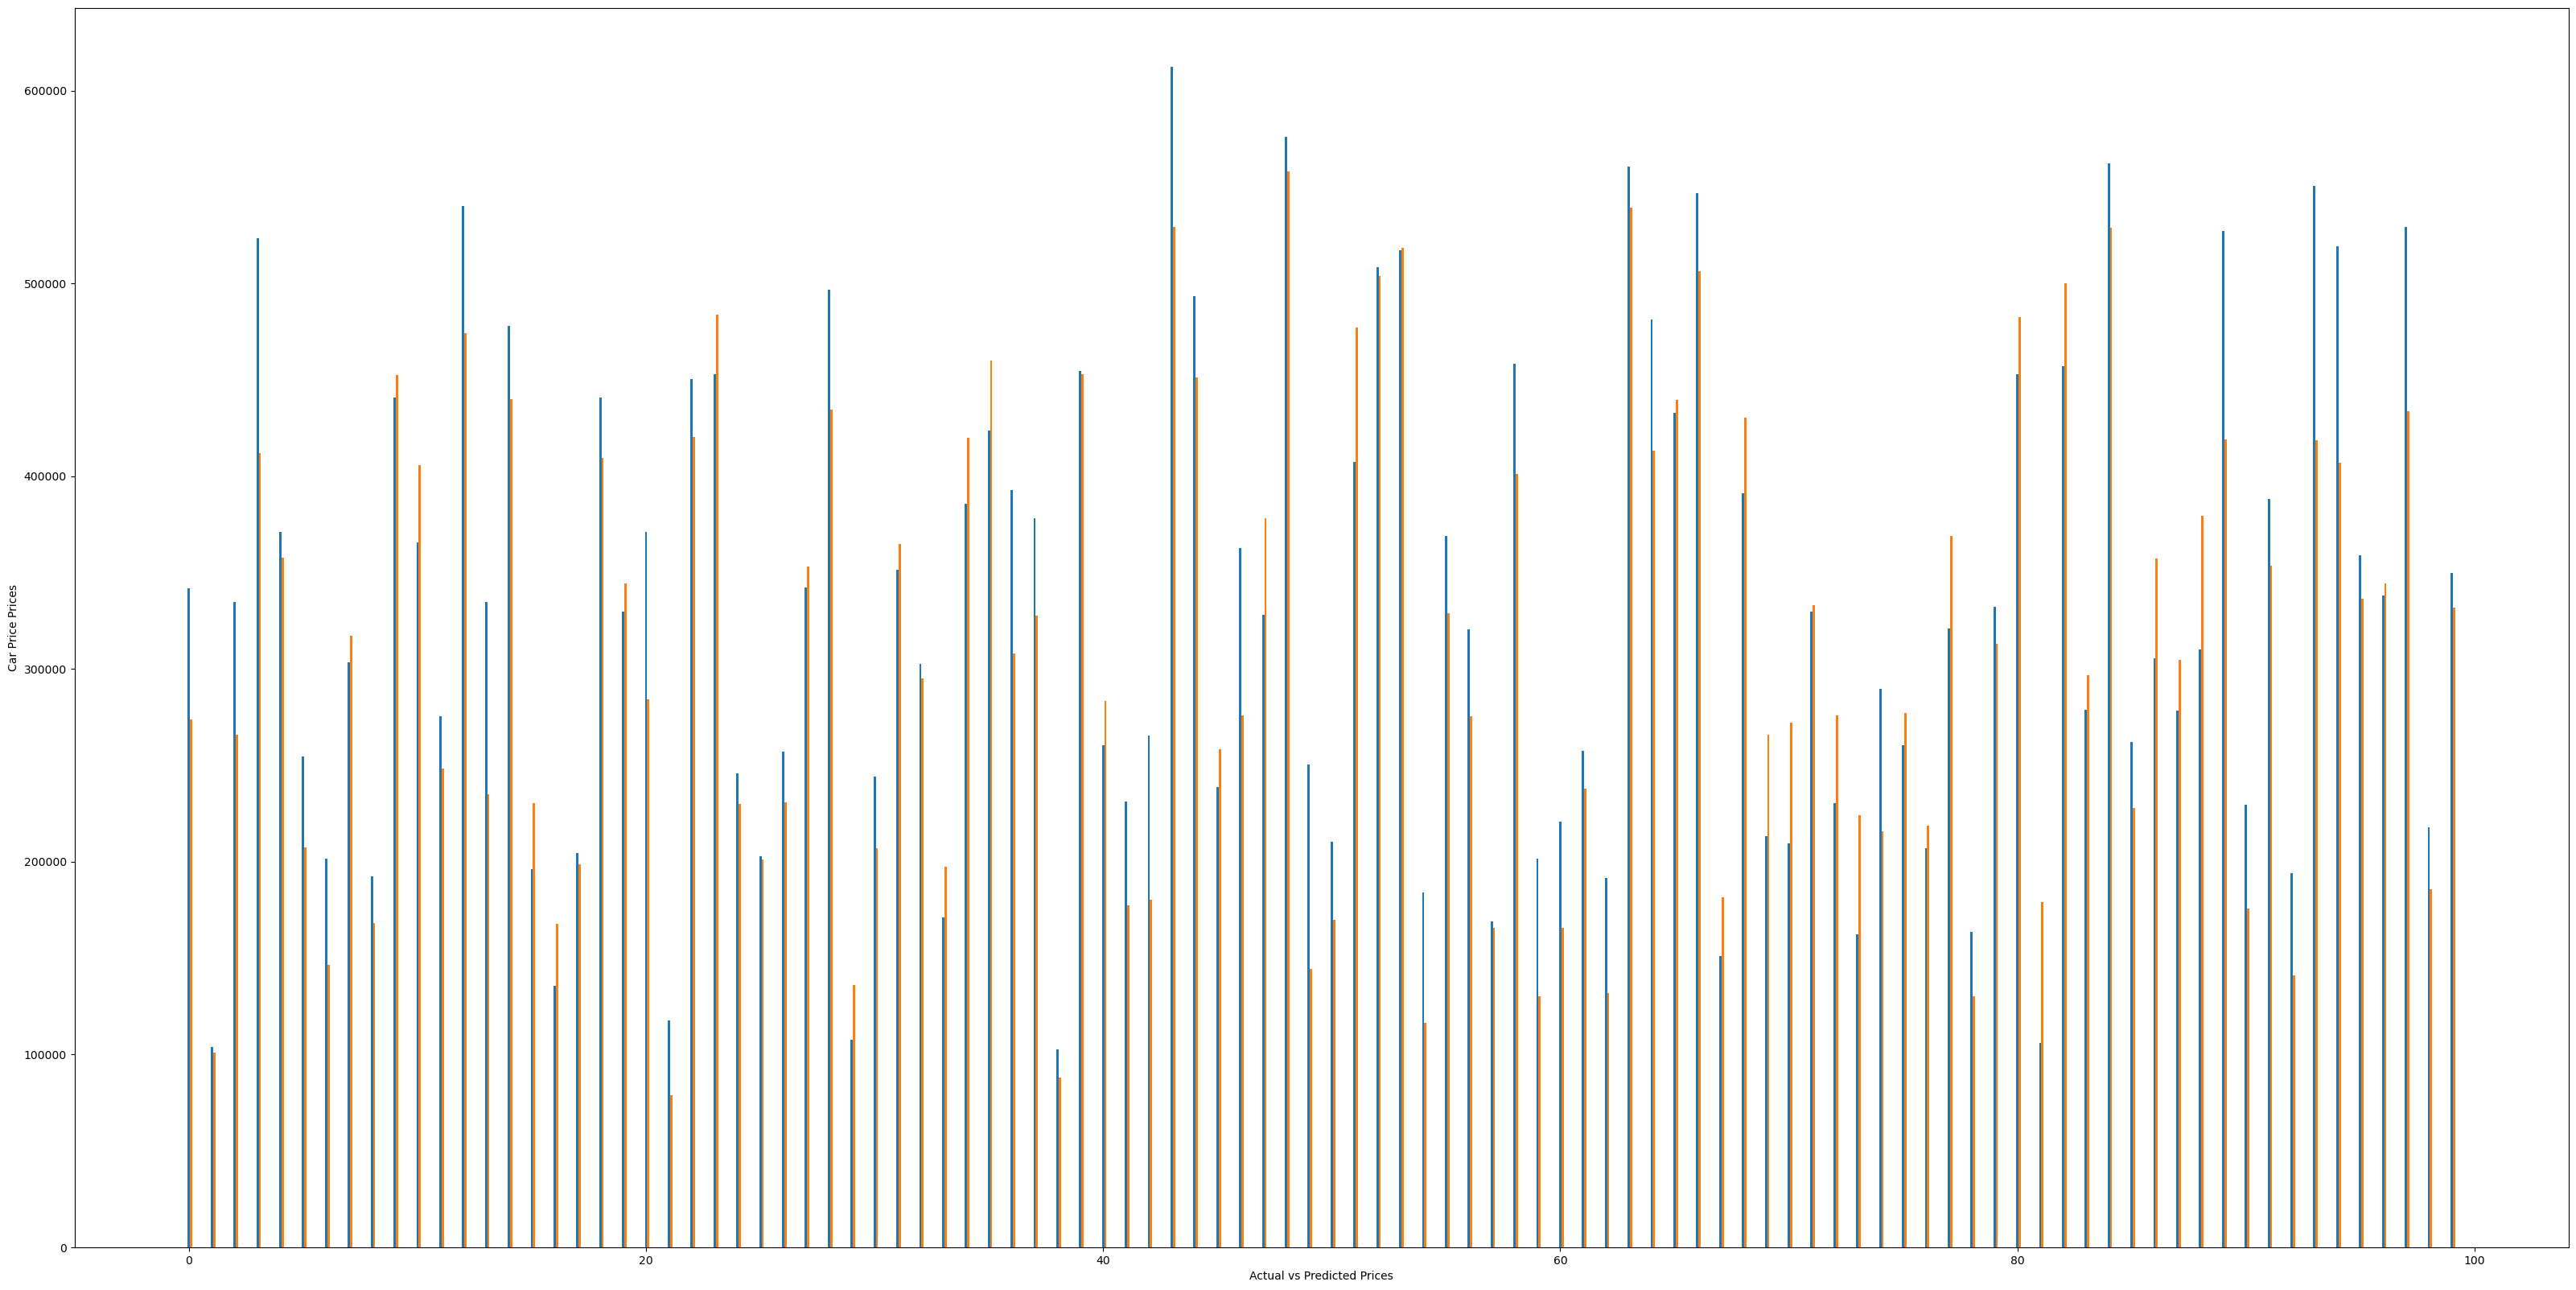

In [34]:
ind = np.arange(100)
plt.figure(figsize=(40,20))

width = 0.1

plt.bar(ind, y_pred, width, label='Predicted Car Price')
plt.bar(ind + width, y_true, width, label='Actual Car Price')

plt.xlabel('Actual vs Predicted Prices')
plt.ylabel('Car Price Prices')

plt.show()